# <center>Payment Delay</center>

Goal of this Project is to create an algorithm that will detect change of behaviour in payment conduct and predict the delay on invoice payment.

For the first part of the project we are focusing on the analysis of the "Days Late" parameter. Which will indicate the amount of days that an invoice was paid before or after its due date.

This notebook will focus on the data exploration and data manipulation to find the right algorithm to be able to predict with a high accuracy the payment delay of invoices. Afterwards we will create steps to implement this project and create a pipeline to be deployed in Azure Machine Learning Environment.


## 1. Getting the invoices data

We will do short data exploration and analysis to the data provided. 

During this step some statistical values will be calculated for the analysis purpose and some manipulations to the raw data will be done, in order to get the desired results.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)


import pickle

# Setting up the display options
# To display all columns/rows from the dataframe, if not wanted, a wide/long dataframe will be truncated
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

# Setting up directories for data
pwd = os.getcwd()
project_dir = os.path.dirname(pwd)

# Defining Path for Raw Data
data_path = os.path.join(project_dir, "data/raw/")

# Defining Path for Processed Data
processed_path = os.path.join(project_dir, "data/processed/")

### 1.1 Load Raw Data

In [2]:
# Data from 03.05.22 -- New File filtering out Intercompany Invoices and not sales related invoices

df = pd.read_csv(data_path + "payment_data.csv")

# We first take a brief look of the dataframe. We proceed to show the first rows of data to corroborate the data has been loaded correctly.
df.head(10)

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,payment_complete,net_amount,payment_amount
0,711762,2019-07-07,NaN,2019-05-10,2019-05-10,5254997,19002778,2019,2019-07-11,20105,SPAIN,W Europe,Europe,Y,6400.000,NaN
1,620848,2023-01-13,NaN,2022-11-29,2022-11-29,8465625,22000680,2022,2023-02-07,597613,CANADA,NAFTA,Americas,Y,45709.650,NaN
2,721222,2021-08-31,NaN,2021-06-10,2021-06-25,6772991,21001083,2021,2021-07-30,693737,HONG KONG SAR,Asia,Asia,Y,70375.371,NaN
3,575612,2023-02-28,NaN,2023-01-05,2023-01-04,8526676,23000022,2023,2023-03-08,574924,MALAYSIA,Asia,Asia,Y,460.270,NaN
4,706813,2022-03-31,NaN,2022-01-25,2022-01-25,7197664,22000073,2022,2022-05-04,525552,MAGHREB,Northern Africa,Africa,Y,12260.030,NaN
5,714266,2020-11-10,NaN,2020-09-10,2020-09-10,6166333,20017084,2020,2020-11-11,20105,SPAIN,W Europe,Europe,Y,16958.000,NaN
6,534934,2019-11-25,NaN,2019-09-25,2019-09-25,5518255,19001251,2019,2019-11-25,527794,SLOVENIJA,E Europe,Europe,Y,12650.000,NaN
7,630460,2020-03-10,NaN,2020-01-10,2020-01-13,5725722,20000488,2020,2020-04-13,533714,UNITED STATES,NAFTA,Americas,Y,27931.660,NaN
8,692118,2022-02-19,NaN,2022-01-19,2022-01-19,7186090,22000222,2022,2022-02-15,12620,BENELUX,W Europe,Europe,Y,32175.000,NaN
9,13170,2020-04-14,NaN,2020-02-10,2020-02-10,5786444,20001067,2020,2020-04-15,12533,FRANCE,W Europe,Europe,Y,11550.000,NaN


In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799577 entries, 0 to 1799576
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   customer_id        1799577 non-null  int64  
 1   due_date           1799577 non-null  object 
 2   due_discount_date  149192 non-null   object 
 3   invoice_date       1799577 non-null  object 
 4   create_date        1799577 non-null  object 
 5   invoice_id         1799577 non-null  int64  
 6   invoice_nr         1799577 non-null  int64  
 7   invoice_year       1799577 non-null  int64  
 8   payment_date       1679795 non-null  object 
 9   company_id         1799577 non-null  int64  
 10  region_level1      1799565 non-null  object 
 11  region_level2      1799577 non-null  object 
 12  region_level3      1799565 non-null  object 
 13  payment_complete   1799577 non-null  object 
 14  net_amount         1799577 non-null  float64
 15  payment_amount     104442 non-nu

### 1.2 Initial Data Manipulation and Data Cleaning

We need to understand the data and see what features add value to our goal. Some data is missing and need to be eliminated. We proceed with an EDA to undertand and decide the factors needed to manipulate the data. After first examination of the data, there are some columns that need some small modifications. These modifications are only to simplify the analysis process. 

- The Data has date columns and we make sure that these are handled as real dates
- Average Days Late analysis is a core feature, so we calculate this feature

In [4]:
# Convert date columns to datetime
date_columns = [
    "invoice_date",
    "create_date",
    "due_date",
    "due_discount_date",
    "payment_date",
]

for col in date_columns:
    df[col] = pd.to_datetime(df[col])
    df = df[
        (df[col].dt.year >= 2010) & (df[col].dt.year <= dt.datetime.now().year)
        | df[col].isnull()
    ]

In [5]:
# get the number of missing data points per column
df.isnull().sum()

customer_id                0
due_date                   0
due_discount_date    1650357
invoice_date               0
create_date                0
invoice_id                 0
invoice_nr                 0
invoice_year               0
payment_date          119782
company_id                 0
region_level1             12
region_level2              0
region_level3             12
payment_complete           0
net_amount                 0
payment_amount       1695107
dtype: int64

We see there are some invoices with missing payment date which is a core feature to determine payment delay. Let's explore these

In [6]:
df[df["payment_date"].isnull()]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,payment_complete,net_amount,payment_amount
29,516099,2023-09-30,NaT,2023-07-07,2023-07-07,8951881,23006613,2023,NaT,12451,ITALY,W Europe,Europe,N,10117.50,12343.350
40,16357,2023-09-30,NaT,2023-07-31,2023-07-31,9004324,23000633,2023,NaT,13087,IRELAND,W Europe,Europe,N,34189.20,42052.720
53,528176,2018-07-31,NaT,2018-06-11,2018-06-11,4599508,18007340,2018,NaT,131,UNITED KINGDOM,W Europe,Europe,Y,0.00,NaN
99,547091,2023-08-15,NaT,2023-06-15,2023-06-15,8900572,23010705,2023,NaT,20105,SPAIN,W Europe,Europe,N,530.25,530.250
101,521087,2022-07-28,2022-07-12,2022-06-30,2022-06-30,8156462,22005256,2022,NaT,373,DACH,W Europe,Europe,Y,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799526,637767,2023-06-15,NaT,2023-06-15,2023-06-15,8900525,23002557,2023,NaT,574921,CHINA,Asia,Asia,N,18188.05,20552.460
1799528,801000,2023-08-02,NaT,2023-07-18,2023-07-18,8973511,4896,2023,NaT,561410,BULGARIA,E Europe,Europe,N,862.81,1035.366
1799542,581416,2023-03-17,NaT,2023-03-02,2023-03-02,8659614,23003419,2023,NaT,148,TURKEY,Middle East,Asia,N,30.42,35.894
1799545,520367,2019-02-16,NaT,2019-01-16,2019-01-16,5009575,19000697,2019,NaT,110,DACH,W Europe,Europe,Y,0.00,NaN


In [7]:
# We can see that not in all cases where there is a missing payment date the payment complete is not always marked as "N". Let's identify the cases where this happens.
df[df["payment_date"].isnull()]["payment_complete"].value_counts()

payment_complete
N    91816
Y    27966
Name: count, dtype: int64

In [8]:
# Let's see how many invoices have a missing payment date and are marked as "Y" to understand the value under payment_amount
df[(df["payment_date"].isnull()) & (df["payment_complete"] == "Y")][
    "payment_amount"
].describe()

count      143.000000
mean      5923.337986
std      13066.231906
min          0.000000
25%          0.000000
50%          0.000000
75%       4192.210000
max      74270.258000
Name: payment_amount, dtype: float64

In [9]:
df[(df["payment_complete"] == "Y") & (df["payment_amount"] > 0)]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,payment_complete,net_amount,payment_amount
162754,17089,2023-07-31,NaT,2023-05-02,2023-05-02,8796862,23002721,2023,NaT,12927,UNITED KINGDOM,W Europe,Europe,Y,23597.50,28317.000
171949,16791,2023-07-31,NaT,2023-05-02,2023-05-02,8796802,23002698,2023,NaT,12927,UNITED KINGDOM,W Europe,Europe,Y,4149.75,4979.700
212714,200405,2023-07-31,NaT,2023-05-02,2023-05-02,8795905,23000761,2023,NaT,158,BENELUX,W Europe,Europe,Y,9350.00,11313.500
310766,729952,2023-07-26,NaT,2023-05-02,2023-05-02,8795597,19371,2023,NaT,13231,BULGARIA,E Europe,Europe,Y,61891.90,74270.258
314669,514950,2023-06-27,NaT,2023-05-02,2023-05-02,8796978,23001474,2023,NaT,12925,SPAIN,W Europe,Europe,Y,5560.00,6727.600
333483,509651,2023-08-02,NaT,2023-05-02,2023-05-02,8795635,23000792,2023,NaT,510586,SLOVAK REPUBLIC,E Europe,Europe,Y,2035.00,2462.350
533397,508053,2023-07-15,NaT,2023-05-02,2023-05-02,8796622,23002666,2023,NaT,124,BENELUX,W Europe,Europe,Y,17640.00,21344.400
553989,16960,2023-07-31,NaT,2023-05-02,2023-05-02,8796835,23002710,2023,NaT,12927,UNITED KINGDOM,W Europe,Europe,Y,3109.14,3730.971
571977,16960,2023-07-31,NaT,2023-05-02,2023-05-02,8796841,23002712,2023,NaT,12927,UNITED KINGDOM,W Europe,Europe,Y,13240.65,15888.790
624885,200741,2023-07-31,NaT,2023-05-02,2023-05-02,8796784,23000708,2023,NaT,525795,BENELUX,W Europe,Europe,Y,27101.25,32792.510


In [10]:
# We remove invoices with missing payment date and as well with payment amount greater than 0 (this indicates the open amount of the invoices). For the purpose of this analysis we will only consider invoices that have been paid.
df = df[
    df["payment_date"].notnull()
    & ~(df["payment_amount"] > 0)
    & (df["payment_complete"] == "Y")
]

df.isnull().sum()

customer_id                0
due_date                   0
due_discount_date    1531300
invoice_date               0
create_date                0
invoice_id                 0
invoice_nr                 0
invoice_year               0
payment_date               0
company_id                 0
region_level1              6
region_level2              0
region_level3              6
payment_complete           0
net_amount                 0
payment_amount       1667284
dtype: int64

In [11]:
df.describe()

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,net_amount,payment_amount
count,1.674418e+06,1674418,143118,1674418,1674418,1.674418e+06,1.674418e+06,1.674418e+06,1674418,1.674418e+06,1.674418e+06,7134.0
mean,5.411407e+05,2020-11-06 23:52:32.627837696,2020-08-29 12:52:56.053326080,2020-09-08 10:17:29.535779072,2020-09-10 04:56:44.070429696,6.371558e+06,1.992959e+07,2.020217e+03,2020-11-10 17:17:20.148876800,2.690045e+05,1.778075e+04,0.0
min,1.040000e+02,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-01 00:00:00,2017-01-02 00:00:00,3.581842e+06,1.000000e+00,2.017000e+03,2010-07-07 00:00:00,-1.000000e+00,-3.617360e+05,0.0
25%,5.185200e+05,2019-05-18 00:00:00,2019-02-11 00:00:00,2019-03-19 00:00:00,2019-03-25 00:00:00,5.153492e+06,1.900067e+07,2.019000e+03,2019-05-22 00:00:00,3.730000e+02,2.273578e+03,0.0
50%,5.869110e+05,2021-01-31 00:00:00,2020-10-24 00:00:00,2020-12-01 00:00:00,2020-12-04 00:00:00,6.342062e+06,2.001691e+07,2.020000e+03,2021-02-04 00:00:00,2.010500e+04,7.215670e+03,0.0
75%,6.784510e+05,2022-06-12 00:00:00,2022-04-21 00:00:00,2022-04-13 00:00:00,2022-04-18 00:00:00,7.646191e+06,2.200161e+07,2.022000e+03,2022-06-17 00:00:00,5.349880e+05,2.476766e+04,0.0
max,8.009900e+05,2024-12-12 00:00:00,2023-09-30 00:00:00,2023-07-28 00:00:00,2023-07-29 00:00:00,9.001780e+06,9.999999e+07,2.023000e+03,2023-08-31 00:00:00,7.875020e+05,1.581654e+08,0.0
std,2.052510e+05,NaN,NaN,NaN,NaN,1.520188e+06,3.140313e+06,1.843599e+00,NaN,2.805472e+05,1.855608e+05,0.0


In [12]:
# Investigate the meaning of company_id == -1
df[df["company_id"] == -1]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,payment_complete,net_amount,payment_amount
143783,510083,2022-10-28,NaT,2022-09-28,2022-09-28,8319063,22000030,2022,2022-11-01,-1,NaN,Southern Africa,NaN,Y,57.25,NaN
661707,651489,2020-12-31,NaT,2020-11-17,2020-11-17,6305460,20000031,2020,2023-05-24,-1,NaN,Southern Africa,NaN,Y,13839.38,NaN
662001,509550,2019-02-15,NaT,2019-01-15,2019-01-15,5007054,19000002,2019,2019-11-19,-1,NaN,Southern Africa,NaN,Y,1995.00,NaN
1091567,510083,2019-07-25,NaT,2019-06-25,2019-06-25,5346163,19000017,2019,2019-10-16,-1,NaN,Southern Africa,NaN,Y,133.55,NaN
1290552,509550,2019-02-17,NaT,2019-01-17,2019-01-17,5012754,19000004,2019,2019-02-11,-1,NaN,Southern Africa,NaN,Y,3990.00,NaN
1510542,509550,2019-02-15,NaT,2019-01-15,2019-01-15,5006794,19000001,2019,2023-03-22,-1,NaN,Southern Africa,NaN,Y,3400.00,NaN


In [13]:
# Let's check why we have negative values in the net_amount column
df[df["net_amount"] < 0]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,payment_complete,net_amount,payment_amount
1022,679864,2020-11-12,NaT,2020-11-12,2021-01-02,6389359,20004766,2020,2022-01-10,580368,UNITED STATES,NAFTA,Americas,Y,-124.078,NaN
1077,679922,2022-09-07,NaT,2022-09-07,2022-10-01,8331380,22901517,2022,2022-11-01,2375,UNITED STATES,NAFTA,Americas,Y,-3177.219,NaN
2185,748489,2021-10-28,NaT,2021-10-28,2022-10-01,8333397,22903534,2022,2023-01-25,2375,UNITED STATES,NAFTA,Americas,Y,-225.041,NaN
3176,679103,2022-08-02,NaT,2022-08-02,2022-10-01,8331653,22901790,2022,2022-11-18,2375,UNITED STATES,NAFTA,Americas,Y,-6245.600,NaN
3328,775211,2022-07-11,NaT,2022-07-11,2022-10-01,8330950,22901087,2022,2022-10-25,2375,UNITED STATES,NAFTA,Americas,Y,-3396.266,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795383,679926,2022-08-16,NaT,2022-08-16,2022-10-01,8341063,22911199,2022,2022-12-20,2375,UNITED STATES,NAFTA,Americas,Y,-2052.116,NaN
1797410,748363,2020-11-19,NaT,2020-11-19,2021-01-02,6388294,20003701,2020,2021-01-04,580368,UNITED STATES,NAFTA,Americas,Y,-2040.231,NaN
1798006,621106,2022-09-23,NaT,2022-09-23,2022-10-01,8329800,22900661,2022,2022-10-18,609347,CANADA,NAFTA,Americas,Y,-9105.799,NaN
1799119,678498,2022-09-20,NaT,2022-09-20,2022-10-01,8341500,22911636,2022,2022-10-04,2375,UNITED STATES,NAFTA,Americas,Y,-4710.595,NaN


In [14]:
df[df["net_amount"] < 0]["region_level3"].value_counts()

region_level3
Americas    1375
Europe       271
Asia         105
Africa         8
Name: count, dtype: int64

In [15]:
# company_id == -1 means the company number is missing. A negative net_amount seems to be a special case, that without any further information we can not determine the real meaning. (We are probably handling debit notes from the company?)
# We will remove these rows from the dataset. We will as well remove the columnt for payment_amount and payment_complete as they are no longer relevant for the analysis.

df = df[(df["company_id"] != -1) & ~(df["net_amount"] < 0)]

df.drop(columns=["payment_amount", "payment_complete"], inplace=True)

df.describe()

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,net_amount
count,1.672653e+06,1672653,143117,1672653,1672653,1.672653e+06,1.672653e+06,1.672653e+06,1672653,1.672653e+06,1.672653e+06
mean,5.409835e+05,2020-11-06 17:02:49.278146816,2020-08-29 12:55:06.173270784,2020-09-08 01:58:31.632120064,2020-09-09 17:09:07.440502784,6.370312e+06,1.992847e+07,2.020216e+03,2020-11-10 04:35:54.946901760,2.690321e+05,1.780907e+04
min,1.040000e+02,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-01 00:00:00,2017-01-02 00:00:00,3.581842e+06,1.000000e+00,2.017000e+03,2010-07-07 00:00:00,1.080000e+02,0.000000e+00
25%,5.183690e+05,2019-05-18 00:00:00,2019-02-11 00:00:00,2019-03-18 00:00:00,2019-03-22 00:00:00,5.152202e+06,1.900066e+07,2.019000e+03,2019-05-22 00:00:00,3.730000e+02,2.282500e+03
50%,5.868060e+05,2021-01-31 00:00:00,2020-10-24 00:00:00,2020-12-01 00:00:00,2020-12-03 00:00:00,6.340360e+06,2.001674e+07,2.020000e+03,2021-02-04 00:00:00,2.010500e+04,7.233940e+03
75%,6.784470e+05,2022-06-12 00:00:00,2022-04-21 00:00:00,2022-04-13 00:00:00,2022-04-15 00:00:00,7.644776e+06,2.200160e+07,2.022000e+03,2022-06-16 00:00:00,5.349880e+05,2.479000e+04
max,8.009900e+05,2024-12-12 00:00:00,2023-09-30 00:00:00,2023-07-28 00:00:00,2023-07-29 00:00:00,9.001780e+06,9.174020e+07,2.023000e+03,2023-08-31 00:00:00,7.875020e+05,1.581654e+08
std,2.052824e+05,NaN,NaN,NaN,NaN,1.519966e+06,3.136104e+06,1.843713e+00,NaN,2.805186e+05,1.856539e+05


<module 'seaborn' from '/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/seaborn/__init__.py'>

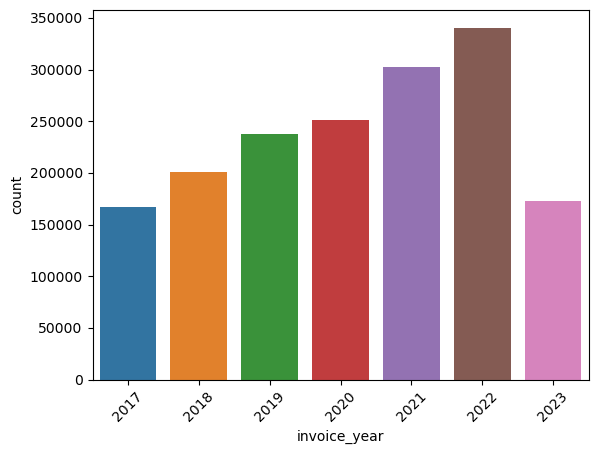

In [16]:
# Count plot of the number of invoices each year
sns.countplot(
    data=df,
    x="invoice_year",
)
plt.xticks(rotation=45)
sns

Let's analyze the date columns

In [17]:
df

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount
0,711762,2019-07-07,NaT,2019-05-10,2019-05-10,5254997,19002778,2019,2019-07-11,20105,SPAIN,W Europe,Europe,6400.000
1,620848,2023-01-13,NaT,2022-11-29,2022-11-29,8465625,22000680,2022,2023-02-07,597613,CANADA,NAFTA,Americas,45709.650
2,721222,2021-08-31,NaT,2021-06-10,2021-06-25,6772991,21001083,2021,2021-07-30,693737,HONG KONG SAR,Asia,Asia,70375.371
3,575612,2023-02-28,NaT,2023-01-05,2023-01-04,8526676,23000022,2023,2023-03-08,574924,MALAYSIA,Asia,Asia,460.270
4,706813,2022-03-31,NaT,2022-01-25,2022-01-25,7197664,22000073,2022,2022-05-04,525552,MAGHREB,Northern Africa,Africa,12260.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799571,661121,2019-12-02,NaT,2019-12-02,2019-12-02,5656733,19005791,2019,2019-12-20,574921,CHINA,Asia,Asia,2522.810
1799572,526236,2022-03-18,NaT,2022-02-21,2022-02-21,7255228,22000548,2022,2022-03-29,542631,POLAND,E Europe,Europe,2668.400
1799574,666728,2017-03-31,NaT,2017-01-24,2017-01-31,3635588,17000129,2017,2017-04-03,664539,AUSTRALIA,Oceania,Oceania,19050.400
1799575,16597,2020-06-30,NaT,2020-05-04,2020-05-06,5942915,20004700,2020,2020-07-10,131,UNITED KINGDOM,W Europe,Europe,6399.460


In [18]:
df[df["payment_date"] < df["invoice_date"]]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount
230,648513,2022-09-07,NaT,2022-09-07,2022-09-07,8279956,22018734,2022,2022-09-06,12529,TURKEY,Middle East,Asia,1600.00
719,750568,2023-07-28,NaT,2023-07-28,2023-07-28,8999539,23011276,2023,2023-07-27,148,TURKEY,Middle East,Asia,25203.27
746,679544,2020-05-11,NaT,2020-05-11,2020-05-13,5955467,20011141,2020,2020-05-07,515785,UNITED STATES,NAFTA,Americas,1199.19
872,680000,2023-01-07,NaT,2022-11-07,2022-11-22,8451548,22026122,2022,2022-09-30,515785,UNITED STATES,NAFTA,Americas,12428.69
1189,747075,2022-08-10,NaT,2022-06-10,2022-06-13,8121181,22007876,2022,2022-05-26,723411,UNITED STATES,NAFTA,Americas,583.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799169,670671,2021-04-07,NaT,2021-04-07,2021-04-07,6603574,21005620,2021,2021-04-06,148,TURKEY,Middle East,Asia,34153.84
1799305,642414,2018-01-04,NaT,2018-01-04,2018-01-04,4272358,18000078,2018,2018-01-03,528512,TURKEY,Middle East,Asia,1646.84
1799399,678771,2019-03-02,NaT,2019-01-16,2019-01-16,5011668,19001470,2019,2019-01-11,515785,UNITED STATES,NAFTA,Americas,3758.97
1799455,656775,2022-11-02,NaT,2022-11-02,2022-11-02,8409730,22023516,2022,2022-11-01,12529,TURKEY,Middle East,Asia,1480.00


We see in these cases the invoice was created after the payment of the invoice was done. These cases will not be taken into account for our analysis so we proceed to remove them.

In [19]:
df = df[(df["invoice_date"] < df["payment_date"])]

df

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount
0,711762,2019-07-07,NaT,2019-05-10,2019-05-10,5254997,19002778,2019,2019-07-11,20105,SPAIN,W Europe,Europe,6400.000
1,620848,2023-01-13,NaT,2022-11-29,2022-11-29,8465625,22000680,2022,2023-02-07,597613,CANADA,NAFTA,Americas,45709.650
2,721222,2021-08-31,NaT,2021-06-10,2021-06-25,6772991,21001083,2021,2021-07-30,693737,HONG KONG SAR,Asia,Asia,70375.371
3,575612,2023-02-28,NaT,2023-01-05,2023-01-04,8526676,23000022,2023,2023-03-08,574924,MALAYSIA,Asia,Asia,460.270
4,706813,2022-03-31,NaT,2022-01-25,2022-01-25,7197664,22000073,2022,2022-05-04,525552,MAGHREB,Northern Africa,Africa,12260.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799571,661121,2019-12-02,NaT,2019-12-02,2019-12-02,5656733,19005791,2019,2019-12-20,574921,CHINA,Asia,Asia,2522.810
1799572,526236,2022-03-18,NaT,2022-02-21,2022-02-21,7255228,22000548,2022,2022-03-29,542631,POLAND,E Europe,Europe,2668.400
1799574,666728,2017-03-31,NaT,2017-01-24,2017-01-31,3635588,17000129,2017,2017-04-03,664539,AUSTRALIA,Oceania,Oceania,19050.400
1799575,16597,2020-06-30,NaT,2020-05-04,2020-05-06,5942915,20004700,2020,2020-07-10,131,UNITED KINGDOM,W Europe,Europe,6399.460


In [20]:
# What about the due date?
df[df["due_date"] < df["invoice_date"]]

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount
2235,728279,2019-10-11,NaT,2019-11-29,2020-01-03,5709441,19991632,2019,2020-01-28,571660,GREECE,W Europe,Europe,217.06
42241,728371,2019-10-16,NaT,2019-11-07,2020-01-03,5709645,19991836,2019,2020-01-27,571660,GREECE,W Europe,Europe,137.58
64724,728379,2019-11-19,NaT,2019-12-16,2020-01-03,5709370,19991561,2019,2020-01-27,571660,GREECE,W Europe,Europe,10935.00
71486,728379,2019-12-10,NaT,2019-12-16,2020-01-03,5709365,19991556,2019,2020-03-16,571660,GREECE,W Europe,Europe,5000.00
78875,728371,2019-11-03,NaT,2019-11-07,2020-01-03,5709654,19991845,2019,2020-01-31,571660,GREECE,W Europe,Europe,2000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713119,713756,2022-06-07,NaT,2022-06-08,2022-06-09,8114432,22011509,2022,2022-06-09,20105,SPAIN,W Europe,Europe,95305.86
1730417,758385,2021-11-13,NaT,2022-06-20,2022-06-21,8138071,22002498,2022,2022-07-05,548189,UNITED STATES,NAFTA,Americas,45794.78
1770560,707209,2019-06-01,NaT,2019-06-18,2019-06-18,5331197,19006124,2019,2019-06-19,20105,SPAIN,W Europe,Europe,7303.80
1775943,728379,2019-12-10,NaT,2019-12-16,2020-01-03,5709368,19991559,2019,2020-03-17,571660,GREECE,W Europe,Europe,3500.00


In [21]:
# Similar as before, we will remove these rows from the dataset
df = df[(df["invoice_date"] < df["due_date"])]

df

,customer_id,due_date,due_discount_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount
0,711762,2019-07-07,NaT,2019-05-10,2019-05-10,5254997,19002778,2019,2019-07-11,20105,SPAIN,W Europe,Europe,6400.000
1,620848,2023-01-13,NaT,2022-11-29,2022-11-29,8465625,22000680,2022,2023-02-07,597613,CANADA,NAFTA,Americas,45709.650
2,721222,2021-08-31,NaT,2021-06-10,2021-06-25,6772991,21001083,2021,2021-07-30,693737,HONG KONG SAR,Asia,Asia,70375.371
3,575612,2023-02-28,NaT,2023-01-05,2023-01-04,8526676,23000022,2023,2023-03-08,574924,MALAYSIA,Asia,Asia,460.270
4,706813,2022-03-31,NaT,2022-01-25,2022-01-25,7197664,22000073,2022,2022-05-04,525552,MAGHREB,Northern Africa,Africa,12260.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799570,200777,2018-08-19,NaT,2018-07-19,2018-07-19,4678790,18002267,2018,2018-08-16,561412,BENELUX,W Europe,Europe,2078.400
1799572,526236,2022-03-18,NaT,2022-02-21,2022-02-21,7255228,22000548,2022,2022-03-29,542631,POLAND,E Europe,Europe,2668.400
1799574,666728,2017-03-31,NaT,2017-01-24,2017-01-31,3635588,17000129,2017,2017-04-03,664539,AUSTRALIA,Oceania,Oceania,19050.400
1799575,16597,2020-06-30,NaT,2020-05-04,2020-05-06,5942915,20004700,2020,2020-07-10,131,UNITED KINGDOM,W Europe,Europe,6399.460


In [22]:
# determine the pairing between customer_id and company_id. Is this a 1:1 relationship?
df.groupby(["customer_id", "company_id"]).size().reset_index(name="count").sort_values(
    by="customer_id"
)

,customer_id,company_id,count
0,115,517217,68
1,115,571660,16
2,123,522013,4
3,160,231,172
4,161,231,113
...,...,...,...
22881,797952,108,1
22882,797954,527949,1
22883,798463,131,1
22884,799914,2375,1


The relationship between customer and company is not 1:1. This means a customer can make business with multiple companies. We assume that the behavior can be different depending on the company they make busines with.

In [23]:
# Sort the dataframe by 'customer_id', 'company_id', and 'invoice_date' and reset the index
df = df.sort_values(by=["customer_id", "company_id", "invoice_date"]).reset_index(
    drop=True
)

### 1.3 Feature Engineering

In [24]:
# We will create special features to determine payment behavior of the customers


def calculate_trend(x):
    """Fit a linear regression and return the slope."""
    if len(x) > 1:
        model = LinearRegression()
        model.fit(np.arange(len(x)).reshape(-1, 1), x)
        return model.coef_[0]
    else:
        return 0


# Calculate feature for payment behaviour
def calculate_features(df):
    # Special situation where a discount or alternative due date is given
    df["discount_offered"] = df["due_discount_date"].apply(
        lambda x: 0 if pd.isna(x) else 1
    )

    # Remove the due_discount_date column
    df.drop("due_discount_date", axis=1, inplace=True)

    # Calculate 'payment_delay'
    df["payment_delay"] = (df["payment_date"] - df["due_date"]).dt.days

    # Group by customer and company
    grouped = df.groupby(["customer_id", "company_id"])

    # Previous payment delay - initialize to 0 for first transaction
    df["previous_payment_delay"] = grouped["payment_delay"].shift()

    df["previous_payment_delay"].fillna(0, inplace=True)

    # Average payment delay until current invoice - initialize to 0 for first transaction
    df["average_payment_delay"] = grouped["payment_delay"].transform(
        lambda x: x.expanding().mean()
    )

    df["average_payment_delay"].fillna(0, inplace=True)

    # Count of previous invoices until current invoice
    df["number_of_previous_invoices"] = grouped.cumcount()

    # Total amount of previous invoices
    df["total_amount_of_previous_invoices"] = grouped["net_amount"].transform(
        lambda x: x.expanding().sum()
    )

    # Average amount of previous invoices
    df["average_invoice_amount"] = df.apply(
        lambda row: (
            0
            if row["number_of_previous_invoices"] == 0
            else row["total_amount_of_previous_invoices"]
            / row["number_of_previous_invoices"]
        ),
        axis=1,
    )

    # Standard deviation in the payment delay - initialize to 0 for first transaction
    df["payment_deviation"] = grouped["payment_delay"].transform(
        lambda x: x.expanding().std()
    )
    df["payment_deviation"].fillna(0, inplace=True)

    # Standard deviation in the invoice amounts - initialize to 0 for first transaction
    df["invoice_deviation"] = grouped["net_amount"].transform(
        lambda x: x.expanding().std()
    )
    df["invoice_deviation"].fillna(0, inplace=True)

    # Has there been any previous delay in payment in the last 3 invoices
    df["has_delayed_payment_last_3"] = (
        grouped["payment_delay"].transform(lambda x: x.rolling(window=3).max()) > 0
    ).astype(int)

    # Has there been any previous delay in payment in the last 3 invoices
    df["has_early_payment_last_3"] = (
        grouped["payment_delay"].transform(lambda x: x.rolling(window=3).max()) < 0
    ).astype(int)

    # Calculate trend of payment delay over time for each customer and company
    df["payment_delay_trend"] = (
        grouped["payment_delay"]
        .transform(lambda x: x.rolling(window=3).mean().diff())
        .fillna(0)
    )

    # Calculate trend of invoice amount over time for each customer and company
    df["invoice_amount_trend"] = (
        grouped["net_amount"]
        .transform(lambda x: x.rolling(window=3).mean().diff())
        .fillna(0)
    )

    # Calculate maximum payment delay until current invoice
    df["maximum_payment_delay"] = grouped["payment_delay"].transform(
        lambda x: x.expanding().max()
    )

    # Overall payment delay trend for each customer and company
    df["overall_payment_delay_trend"] = grouped["payment_delay"].transform(
        calculate_trend
    )

    return df


calculate_features(df)

,customer_id,due_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount,discount_offered,payment_delay,previous_payment_delay,average_payment_delay,number_of_previous_invoices,total_amount_of_previous_invoices,average_invoice_amount,payment_deviation,invoice_deviation,has_delayed_payment_last_3,has_early_payment_last_3,payment_delay_trend,invoice_amount_trend,maximum_payment_delay,overall_payment_delay_trend
0,115,2017-10-09,2017-07-11,2017-12-11,4236866,25240001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,105,0.0,105.000000,0,0.01,0.000000,0.000000,0.000000,0,0,0.000000,0.00,105.0,-0.609497
1,115,2017-12-05,2017-09-06,2017-12-11,4237475,3118,2017,2018-01-22,517217,GREECE,W Europe,Europe,1212.10,0,48,105.0,76.500000,1,1212.11,1212.110000,40.305087,857.077058,0,0,0.000000,0.00,105.0,-0.609497
2,115,2017-12-18,2017-09-19,2017-12-11,4237687,32910002,2017,2018-01-22,517217,GREECE,W Europe,Europe,130.19,0,35,48.0,62.666667,2,1342.30,671.150000,37.233497,665.411934,1,0,0.000000,0.00,105.0,-0.609497
3,115,2017-12-18,2017-09-19,2017-12-11,4237686,32910001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,35,35.0,55.750000,3,1342.31,447.436667,33.400349,587.561858,1,0,-23.333333,0.00,105.0,-0.609497
4,115,2018-01-08,2017-10-10,2017-12-11,4238055,3605,2017,2018-02-20,517217,GREECE,W Europe,Europe,0.01,0,43,35.0,53.200000,4,1342.32,335.580000,29.482198,530.511840,1,0,-1.666667,-404.03,105.0,-0.609497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615836,797952,2023-07-21,2023-06-22,2023-06-22,8917598,23004453,2023,2023-07-24,108,POLAND,E Europe,Europe,146.33,0,3,0.0,3.000000,0,146.33,0.000000,0.000000,0.000000,0,0,0.000000,0.00,3.0,0.000000
1615837,797954,2023-07-16,2023-06-16,2023-06-16,8903398,23001098,2023,2023-06-30,527949,DACH,W Europe,Europe,4179.30,0,-16,0.0,-16.000000,0,4179.30,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-16.0,0.000000
1615838,798463,2023-07-31,2023-06-23,2023-06-23,8920077,23005745,2023,2023-06-26,131,UNITED KINGDOM,W Europe,Europe,5267.38,0,-35,0.0,-35.000000,0,5267.38,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-35.0,0.000000
1615839,799914,2023-07-23,2023-06-23,2023-06-26,8925188,23037335,2023,2023-07-05,2375,UNITED STATES,NAFTA,Americas,2429.07,0,-18,0.0,-18.000000,0,2429.07,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-18.0,0.000000


In [25]:
# We will calculate some time related features to understand seasonality effects on the payment behavior of the customers


def calculate_trend_features(df):
    # Convert to datetime if it's not already
    df["due_date"] = pd.to_datetime(df["due_date"])

    # Features for the time of the year
    df["due_date_month"] = df["due_date"].dt.month
    df["due_date_quarter"] = df["due_date"].dt.quarter
    df["due_date_dayofweek"] = df["due_date"].dt.dayofweek

    df["due_date_is_year_end"] = (df["due_date"].dt.month == 12).astype(int)
    df["due_date_is_year_start"] = (df["due_date"].dt.month == 1).astype(int)

    # Due date is in summer time (June, July, August)
    df["due_date_is_summer"] = df["due_date"].dt.month.isin([6, 7, 8]).astype(int)

    # Group by customer and company
    grouped = df.groupby(["customer_id", "company_id"])

    # Rate of change of the delay (second derivative)
    df["payment_delay_trend_acceleration"] = (
        grouped["payment_delay"].transform(lambda x: x.diff().diff()).fillna(0)
    )

    # Variance in payment behavior over time
    df["payment_delay_variance"] = (
        grouped["payment_delay"].transform(lambda x: x.expanding().std()).fillna(0)
    )

    return df


calculate_trend_features(df)

,customer_id,due_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount,discount_offered,payment_delay,previous_payment_delay,average_payment_delay,number_of_previous_invoices,total_amount_of_previous_invoices,average_invoice_amount,payment_deviation,invoice_deviation,has_delayed_payment_last_3,has_early_payment_last_3,payment_delay_trend,invoice_amount_trend,maximum_payment_delay,overall_payment_delay_trend,due_date_month,due_date_quarter,due_date_dayofweek,due_date_is_year_end,due_date_is_year_start,due_date_is_summer,payment_delay_trend_acceleration,payment_delay_variance
0,115,2017-10-09,2017-07-11,2017-12-11,4236866,25240001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,105,0.0,105.000000,0,0.01,0.000000,0.000000,0.000000,0,0,0.000000,0.00,105.0,-0.609497,10,4,0,0,0,0,0.0,0.000000
1,115,2017-12-05,2017-09-06,2017-12-11,4237475,3118,2017,2018-01-22,517217,GREECE,W Europe,Europe,1212.10,0,48,105.0,76.500000,1,1212.11,1212.110000,40.305087,857.077058,0,0,0.000000,0.00,105.0,-0.609497,12,4,1,1,0,0,0.0,40.305087
2,115,2017-12-18,2017-09-19,2017-12-11,4237687,32910002,2017,2018-01-22,517217,GREECE,W Europe,Europe,130.19,0,35,48.0,62.666667,2,1342.30,671.150000,37.233497,665.411934,1,0,0.000000,0.00,105.0,-0.609497,12,4,0,1,0,0,44.0,37.233497
3,115,2017-12-18,2017-09-19,2017-12-11,4237686,32910001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,35,35.0,55.750000,3,1342.31,447.436667,33.400349,587.561858,1,0,-23.333333,0.00,105.0,-0.609497,12,4,0,1,0,0,13.0,33.400349
4,115,2018-01-08,2017-10-10,2017-12-11,4238055,3605,2017,2018-02-20,517217,GREECE,W Europe,Europe,0.01,0,43,35.0,53.200000,4,1342.32,335.580000,29.482198,530.511840,1,0,-1.666667,-404.03,105.0,-0.609497,1,1,0,0,1,0,8.0,29.482198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615836,797952,2023-07-21,2023-06-22,2023-06-22,8917598,23004453,2023,2023-07-24,108,POLAND,E Europe,Europe,146.33,0,3,0.0,3.000000,0,146.33,0.000000,0.000000,0.000000,0,0,0.000000,0.00,3.0,0.000000,7,3,4,0,0,1,0.0,0.000000
1615837,797954,2023-07-16,2023-06-16,2023-06-16,8903398,23001098,2023,2023-06-30,527949,DACH,W Europe,Europe,4179.30,0,-16,0.0,-16.000000,0,4179.30,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-16.0,0.000000,7,3,6,0,0,1,0.0,0.000000
1615838,798463,2023-07-31,2023-06-23,2023-06-23,8920077,23005745,2023,2023-06-26,131,UNITED KINGDOM,W Europe,Europe,5267.38,0,-35,0.0,-35.000000,0,5267.38,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-35.0,0.000000,7,3,0,0,0,1,0.0,0.000000
1615839,799914,2023-07-23,2023-06-23,2023-06-26,8925188,23037335,2023,2023-07-05,2375,UNITED STATES,NAFTA,Americas,2429.07,0,-18,0.0,-18.000000,0,2429.07,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-18.0,0.000000,7,3,6,0,0,1,0.0,0.000000


In [26]:
# We will calculate some business related features to understand the business behavior of the customers and summarize them in a global score


def calculate_risk_tolerance_score(df):
    # Get the necessary data
    average_payment_delay = df["average_payment_delay"]
    has_delayed_payment_last_3 = df["has_delayed_payment_last_3"]
    maximum_payment_delay = df["maximum_payment_delay"]
    overall_payment_delay_trend = df["overall_payment_delay_trend"]
    number_of_previous_invoices = df["number_of_previous_invoices"]
    invoice_deviation = df["invoice_deviation"]
    net_amount = df["net_amount"]
    average_invoice_amount = df["average_invoice_amount"]
    # discount_offered = df["discount_offered"]

    # Normalize these values for scoring
    # In this case, I'll assume higher value indicates higher risk for delay related features
    # and higher value indicates lower risk for value related features
    # For binary variables like `has_delayed_payment_last_3`, no normalization is needed.
    # Inverse because higher delay should lower the score
    average_payment_delay_score = 1 - (
        (average_payment_delay - df["average_payment_delay"].min())
        / (df["average_payment_delay"].max() - df["average_payment_delay"].min())
    )
    maximum_payment_delay_score = 1 - (
        (maximum_payment_delay - df["maximum_payment_delay"].min())
        / (df["maximum_payment_delay"].max() - df["maximum_payment_delay"].min())
    )
    overall_payment_delay_trend_score = 1 - (
        (overall_payment_delay_trend - df["overall_payment_delay_trend"].min())
        / (
            df["overall_payment_delay_trend"].max()
            - df["overall_payment_delay_trend"].min()
        )
    )
    invoice_deviation_score = (invoice_deviation - df["invoice_deviation"].min()) / (
        df["invoice_deviation"].max() - df["invoice_deviation"].min()
    )
    number_of_previous_invoices_score = (
        number_of_previous_invoices - df["number_of_previous_invoices"].min()
    ) / (
        df["number_of_previous_invoices"].max()
        - df["number_of_previous_invoices"].min()
    )
    net_amount_score = (net_amount - df["net_amount"].min()) / (
        df["net_amount"].max() - df["net_amount"].min()
    )
    average_invoice_amount_score = (
        average_invoice_amount - df["average_invoice_amount"].min()
    ) / (df["average_invoice_amount"].max() - df["average_invoice_amount"].min())
    # discount_offered_score = (discount_offered - df["discount_offered"].min()) / (
    #     df["discount_offered"].max() - df["discount_offered"].min()
    # )

    # Combine these factors into a single risk tolerance score
    # The weights can be adjusted based on business requirements.
    risk_tolerance_score = (
        0.2 * average_payment_delay_score
        + 0.2 * maximum_payment_delay_score
        + 0.1 * overall_payment_delay_trend_score
        + 0.2 * has_delayed_payment_last_3
        + 0.1 * invoice_deviation_score
        + 0.1 * number_of_previous_invoices_score
        + 0.1 * net_amount_score
        + 0.1 * average_invoice_amount_score
        # + 0.01 * discount_offered_score
    ) * 10

    risk_tolerance_score = risk_tolerance_score.where(
        ~np.isnan(risk_tolerance_score), -1
    )

    return risk_tolerance_score


def calculate_customer_value_score(df):
    # Get the necessary data
    net_amount = df["net_amount"]
    average_invoice_amount = df["average_invoice_amount"]
    number_of_previous_invoices = df["number_of_previous_invoices"]

    # Define the frequency of transactions
    df["frequency_of_transactions"] = df.groupby("customer_id")["invoice_id"].transform(
        "count"
    )

    # Define recency: the more recent, the higher the score
    latest_transaction = (df["invoice_date"].max() - df["invoice_date"]).dt.days

    # Normalize these values for scoring
    net_amount_score = (net_amount - df["net_amount"].min()) / (
        df["net_amount"].max() - df["net_amount"].min()
    )
    average_invoice_amount_score = (
        average_invoice_amount - df["average_invoice_amount"].min()
    ) / (df["average_invoice_amount"].max() - df["average_invoice_amount"].min())
    number_of_previous_invoices_score = (
        number_of_previous_invoices - df["number_of_previous_invoices"].min()
    ) / (
        df["number_of_previous_invoices"].max()
        - df["number_of_previous_invoices"].min()
    )

    frequency_of_transactions_score = (
        df["frequency_of_transactions"] - df["frequency_of_transactions"].min()
    ) / (df["frequency_of_transactions"].max() - df["frequency_of_transactions"].min())

    latest_transaction_score = (latest_transaction - latest_transaction.min()) / (
        latest_transaction.max() - latest_transaction.min()
    )
    latest_transaction_score = (
        1 - latest_transaction_score
    )  # Reverse the score: the more recent, the higher the score

    # Combine these factors into a single customer value score
    # The weights can be adjusted based on business requirements.
    customer_value_score = (
        0.3 * net_amount_score
        + 0.2 * average_invoice_amount_score
        + 0.1 * number_of_previous_invoices_score
        + 0.2 * frequency_of_transactions_score
        + 0.2 * latest_transaction_score
    ) * 10

    customer_value_score = customer_value_score.where(
        ~np.isnan(customer_value_score), -1
    )

    return customer_value_score


def calculate_cash_flow_score(df):
    # Calculate average payment delay
    average_payment_delay = df["average_payment_delay"]

    # Customers who consistently pay on time should have a higher score
    # We can calculate this by using the standard deviation of the payment delays
    consistency = df["payment_delay_variance"]

    # Total income from this customer
    customer_income = df["net_amount"]

    # Normalize these values for scoring
    average_payment_delay_score = 1 - (
        (average_payment_delay - df["average_payment_delay"].min())
        / (df["average_payment_delay"].max() - df["average_payment_delay"].min())
    )  # inverse because higher delay should lower the score
    consistency_score = 1 - (
        (consistency - df["payment_delay_variance"].min())
        / (df["payment_delay_variance"].max() - df["payment_delay_variance"].min())
    )  # inverse because higher variance should lower the score
    customer_income_score = (customer_income - df["net_amount"].min()) / (
        df["net_amount"].max() - df["net_amount"].min()
    )

    # Combine these factors into a single cash flow score
    # The weights can be adjusted based on business requirements
    cash_flow_score = (
        0.3 * average_payment_delay_score
        + 0.3 * consistency_score
        + 0.4 * customer_income_score
    ) * 10

    cash_flow_score = cash_flow_score.where(~np.isnan(cash_flow_score), -1)

    return cash_flow_score


def calculate_historical_score(df):
    alpha = 0.1  # decay parameter, adjust as needed

    # Calculate the weighted trend score with exponential decay
    df["weighted_payment_delay_trend"] = df["payment_delay_trend"].apply(
        lambda x: alpha * (1 - alpha) ** x * x
    )
    payment_delay_trend_score = 1 - (
        (df["weighted_payment_delay_trend"] - df["weighted_payment_delay_trend"].min())
        / (
            df["weighted_payment_delay_trend"].max()
            - df["weighted_payment_delay_trend"].min()
        )
    )  # inverse because higher delay trend should lower the score

    # We consider the maximum payment delay a customer has ever had
    max_payment_delay = df["maximum_payment_delay"]

    # Calculate the weighted consistency score with exponential decay
    df["weighted_payment_delay_variance"] = df["payment_delay_variance"].apply(
        lambda x: alpha * (1 - alpha) ** x * x
    )
    consistency_score = 1 - (
        (
            df["weighted_payment_delay_variance"]
            - df["weighted_payment_delay_variance"].min()
        )
        / (
            df["weighted_payment_delay_variance"].max()
            - df["weighted_payment_delay_variance"].min()
        )
    )  # inverse because higher variance should lower the score

    # Normalize max delay for scoring
    max_payment_delay_score = 1 - (
        (max_payment_delay - df["maximum_payment_delay"].min())
        / (df["maximum_payment_delay"].max() - df["maximum_payment_delay"].min())
    )  # inverse because higher max delay should lower the score

    # Combine these factors into a single historical score
    # The weights can be adjusted based on business requirements. For instance, we give a higher weight to the trend score.
    historical_score = (
        0.5 * payment_delay_trend_score
        + 0.25 * max_payment_delay_score
        + 0.25 * consistency_score
    ) * 10

    historical_score = historical_score.where(~np.isnan(historical_score), -1)

    return historical_score


def calculate_global_score(df):
    # Calculate individual scores
    df["risk_tolerance_score"] = calculate_risk_tolerance_score(df)
    df["customer_value_score"] = calculate_customer_value_score(df)
    df["cash_flow_score"] = calculate_cash_flow_score(df)
    df["historical_score"] = calculate_historical_score(df)

    # If any individual score is -1, then set composite score as -1
    df.loc[
        (df["risk_tolerance_score"] == -1)
        | (df["customer_value_score"] == -1)
        | (df["cash_flow_score"] == -1)
        | (df["historical_score"] == -1),
        [
            "risk_tolerance_score",
            "customer_value_score",
            "cash_flow_score",
            "historical_score",
            "global_score",
        ],
    ] = -1

    # Define weights based on business context (these need to be refined)
    weights = {
        "risk_tolerance_score": 0.10,  # 25% weight
        "customer_value_score": 0.35,  # 25% weight
        "cash_flow_score": 0.05,  # 25% weight
        "historical_score": 0.50,  # 25% weight
    }

    # If composite score is not already -1, calculate composite score
    mask = df["global_score"] != -1
    df.loc[mask, "global_score"] = (
        df.loc[mask, "risk_tolerance_score"] * weights["risk_tolerance_score"]
        + df.loc[mask, "customer_value_score"] * weights["customer_value_score"]
        + df.loc[mask, "cash_flow_score"] * weights["cash_flow_score"]
        + df.loc[mask, "historical_score"] * weights["historical_score"]
    )

    # Normalize the composite score to have a range of 0-10
    df.loc[mask, "global_score"] = (
        df.loc[mask, "global_score"] / df.loc[mask, "global_score"].max()
    ) * 10

    return df


calculate_global_score(df)

,customer_id,due_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount,discount_offered,payment_delay,previous_payment_delay,average_payment_delay,number_of_previous_invoices,total_amount_of_previous_invoices,average_invoice_amount,payment_deviation,invoice_deviation,has_delayed_payment_last_3,has_early_payment_last_3,payment_delay_trend,invoice_amount_trend,maximum_payment_delay,overall_payment_delay_trend,due_date_month,due_date_quarter,due_date_dayofweek,due_date_is_year_end,due_date_is_year_start,due_date_is_summer,payment_delay_trend_acceleration,payment_delay_variance,risk_tolerance_score,frequency_of_transactions,customer_value_score,cash_flow_score,weighted_payment_delay_trend,weighted_payment_delay_variance,historical_score,global_score
0,115,2017-10-09,2017-07-11,2017-12-11,4236866,25240001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,105,0.0,105.000000,0,0.01,0.000000,0.000000,0.000000,0,0,0.000000,0.00,105.0,-0.609497,10,4,0,0,0,0,0.0,0.000000,3.693895,84,0.189284,5.456547,0.000000,0.000000,4.547122,5.559958
1,115,2017-12-05,2017-09-06,2017-12-11,4237475,3118,2017,2018-01-22,517217,GREECE,W Europe,Europe,1212.10,0,48,105.0,76.500000,1,1212.11,1212.110000,40.305087,857.077058,0,0,0.000000,0.00,105.0,-0.609497,12,4,1,1,0,0,0.0,40.305087,3.716156,84,0.237088,5.391720,0.000000,0.057690,4.134063,5.204188
2,115,2017-12-18,2017-09-19,2017-12-11,4237687,32910002,2017,2018-01-22,517217,GREECE,W Europe,Europe,130.19,0,35,48.0,62.666667,2,1342.30,671.150000,37.233497,665.411934,1,0,0.000000,0.00,105.0,-0.609497,12,4,0,1,0,0,44.0,37.233497,5.726995,84,0.248050,5.415181,0.000000,0.073658,4.019729,5.481861
3,115,2017-12-18,2017-09-19,2017-12-11,4237686,32910001,2017,2018-01-22,517217,GREECE,W Europe,Europe,0.01,0,35,35.0,55.750000,3,1342.31,447.436667,33.400349,587.561858,1,0,-23.333333,0.00,105.0,-0.609497,12,4,0,1,0,0,13.0,33.400349,5.732509,84,0.248214,5.432502,-27.267892,0.098954,3.838610,5.315764
4,115,2018-01-08,2017-10-10,2017-12-11,4238055,3605,2017,2018-02-20,517217,GREECE,W Europe,Europe,0.01,0,43,35.0,53.200000,4,1342.32,335.580000,29.482198,530.511840,1,0,-1.666667,-404.03,105.0,-0.609497,1,1,0,0,1,0,8.0,29.482198,5.734655,84,0.265895,5.444972,-0.198660,0.131986,3.602103,5.108381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615836,797952,2023-07-21,2023-06-22,2023-06-22,8917598,23004453,2023,2023-07-24,108,POLAND,E Europe,Europe,146.33,0,3,0.0,3.000000,0,146.33,0.000000,0.000000,0.000000,0,0,0.000000,0.00,3.0,0.000000,7,3,4,0,0,1,0.0,0.000000,3.851071,1,1.969990,5.574743,0.000000,0.000000,4.645616,6.854140
1615837,797954,2023-07-16,2023-06-16,2023-06-16,8903398,23001098,2023,2023-06-30,527949,DACH,W Europe,Europe,4179.30,0,-16,0.0,-16.000000,0,4179.30,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-16.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.880451,1,1.965065,5.596861,0.000000,0.000000,4.663963,6.875570
1615838,798463,2023-07-31,2023-06-23,2023-06-23,8920077,23005745,2023,2023-06-26,131,UNITED KINGDOM,W Europe,Europe,5267.38,0,-35,0.0,-35.000000,0,5267.38,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-35.0,0.000000,7,3,0,0,0,1,0.0,0.000000,3.909813,1,1.970921,5.618905,0.000000,0.000000,4.682310,6.904025
1615839,799914,2023-07-23,2023-06-23,2023-06-26,8925188,23037335,2023,2023-07-05,2375,UNITED STATES,NAFTA,Americas,2429.07,0,-18,0.0,-18.000000,0,2429.07,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-18.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.883530,1,1.970867,5.599134,0.000000,0.000000,4.665894,6.881943


**Risk Tolerance Score (0-10):** This score quantifies the level of payment risk associated with a particular customer. A lower score (closer to 0) suggests that the customer is high risk, i.e., there is a significant chance of delayed payment or default based on the customer's past behaviour. This is reflected in things like a high average payment delay, frequent delayed payments, a trend of increasing payment delay, etc. A higher score (closer to 10) means the customer is low risk and generally pays their invoices on time.

**Customer Value Score (0-10):** This score represents the financial value of the customer to the business. Customers who have purchased frequently and recently, and who typically make large purchases, will have higher scores (closer to 10). Customers who purchase infrequently, make small purchases, or have not purchased recently will have lower scores (closer to 0).

**Cash Flow Score (0-10):** This score represents the predictability and reliability of the cash flow from a customer. A high score (closer to 10) suggests that the customer consistently pays their invoices on time, leading to a reliable and predictable cash flow. A low score (closer to 0) indicates that the customer's payment behaviour is inconsistent, which makes the cash flow from this customer unreliable.

**Historical Score (0-10):** This score captures the historical payment behaviour of a customer, with recent behaviour weighted more heavily. A high score (closer to 10) means that the customer has been improving in their payment behaviour over time, i.e., they are paying their invoices sooner. A low score (closer to 0) suggests the customer's payment behaviour has been deteriorating over time, i.e., they are taking longer to pay their invoices.

In each case, a higher score is better from the business's perspective, as it suggests a customer who provides more value and less risk to the business. These scores help the business to make informed decisions about credit terms, marketing efforts, etc., for each customer. Note that the specific meaning of these scores can be adjusted by changing the factors and weights used in their calculation, according to the business's specific needs and context.

In [27]:
# transform region_level1, region_level2, region_level3 to categorical and then to numerical
categorical_columns = [
    "region_level1",
    "region_level2",
    "region_level3",
]

df[categorical_columns] = df[categorical_columns].astype("category")
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

df

,customer_id,due_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount,discount_offered,payment_delay,previous_payment_delay,average_payment_delay,number_of_previous_invoices,total_amount_of_previous_invoices,average_invoice_amount,payment_deviation,invoice_deviation,has_delayed_payment_last_3,has_early_payment_last_3,payment_delay_trend,invoice_amount_trend,maximum_payment_delay,overall_payment_delay_trend,due_date_month,due_date_quarter,due_date_dayofweek,due_date_is_year_end,due_date_is_year_start,due_date_is_summer,payment_delay_trend_acceleration,payment_delay_variance,risk_tolerance_score,frequency_of_transactions,customer_value_score,cash_flow_score,weighted_payment_delay_trend,weighted_payment_delay_variance,historical_score,global_score
0,115,2017-10-09,2017-07-11,2017-12-11,4236866,25240001,2017,2018-01-22,517217,14,8,3,0.01,0,105,0.0,105.000000,0,0.01,0.000000,0.000000,0.000000,0,0,0.000000,0.00,105.0,-0.609497,10,4,0,0,0,0,0.0,0.000000,3.693895,84,0.189284,5.456547,0.000000,0.000000,4.547122,5.559958
1,115,2017-12-05,2017-09-06,2017-12-11,4237475,3118,2017,2018-01-22,517217,14,8,3,1212.10,0,48,105.0,76.500000,1,1212.11,1212.110000,40.305087,857.077058,0,0,0.000000,0.00,105.0,-0.609497,12,4,1,1,0,0,0.0,40.305087,3.716156,84,0.237088,5.391720,0.000000,0.057690,4.134063,5.204188
2,115,2017-12-18,2017-09-19,2017-12-11,4237687,32910002,2017,2018-01-22,517217,14,8,3,130.19,0,35,48.0,62.666667,2,1342.30,671.150000,37.233497,665.411934,1,0,0.000000,0.00,105.0,-0.609497,12,4,0,1,0,0,44.0,37.233497,5.726995,84,0.248050,5.415181,0.000000,0.073658,4.019729,5.481861
3,115,2017-12-18,2017-09-19,2017-12-11,4237686,32910001,2017,2018-01-22,517217,14,8,3,0.01,0,35,35.0,55.750000,3,1342.31,447.436667,33.400349,587.561858,1,0,-23.333333,0.00,105.0,-0.609497,12,4,0,1,0,0,13.0,33.400349,5.732509,84,0.248214,5.432502,-27.267892,0.098954,3.838610,5.315764
4,115,2018-01-08,2017-10-10,2017-12-11,4238055,3605,2017,2018-02-20,517217,14,8,3,0.01,0,43,35.0,53.200000,4,1342.32,335.580000,29.482198,530.511840,1,0,-1.666667,-404.03,105.0,-0.609497,1,1,0,0,1,0,8.0,29.482198,5.734655,84,0.265895,5.444972,-0.198660,0.131986,3.602103,5.108381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615836,797952,2023-07-21,2023-06-22,2023-06-22,8917598,23004453,2023,2023-07-24,108,27,1,3,146.33,0,3,0.0,3.000000,0,146.33,0.000000,0.000000,0.000000,0,0,0.000000,0.00,3.0,0.000000,7,3,4,0,0,1,0.0,0.000000,3.851071,1,1.969990,5.574743,0.000000,0.000000,4.645616,6.854140
1615837,797954,2023-07-16,2023-06-16,2023-06-16,8903398,23001098,2023,2023-06-30,527949,10,8,3,4179.30,0,-16,0.0,-16.000000,0,4179.30,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-16.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.880451,1,1.965065,5.596861,0.000000,0.000000,4.663963,6.875570
1615838,798463,2023-07-31,2023-06-23,2023-06-23,8920077,23005745,2023,2023-06-26,131,44,8,3,5267.38,0,-35,0.0,-35.000000,0,5267.38,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-35.0,0.000000,7,3,0,0,0,1,0.0,0.000000,3.909813,1,1.970921,5.618905,0.000000,0.000000,4.682310,6.904025
1615839,799914,2023-07-23,2023-06-23,2023-06-26,8925188,23037335,2023,2023-07-05,2375,45,3,1,2429.07,0,-18,0.0,-18.000000,0,2429.07,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-18.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.883530,1,1.970867,5.599134,0.000000,0.000000,4.665894,6.881943


In [28]:
# Create the target variable. We will create buckets of 15 days for the payment delay
bins = [-np.inf, 15, 30, 45, 60, np.inf]
labels = [0, 1, 2, 3, 4]

# "payment_bucket" will be defined as follow
# 0: payment delay <= 15 days
# 1: 15 < payment delay <= 30 days
# 2: 30 < payment delay <= 45 days
# 3: 45 < payment delay <= 60 days
# 4: payment delay > 60 days

# Only create 'payment_bucket' where 'payment_delay' is not null
df.loc[df["payment_date"].notna(), "payment_bucket"] = pd.cut(
    df.loc[df["payment_date"].notna(), "payment_delay"], bins=bins, labels=labels
).astype(int)

df

,customer_id,due_date,invoice_date,create_date,invoice_id,invoice_nr,invoice_year,payment_date,company_id,region_level1,region_level2,region_level3,net_amount,discount_offered,payment_delay,previous_payment_delay,average_payment_delay,number_of_previous_invoices,total_amount_of_previous_invoices,average_invoice_amount,payment_deviation,invoice_deviation,has_delayed_payment_last_3,has_early_payment_last_3,payment_delay_trend,invoice_amount_trend,maximum_payment_delay,overall_payment_delay_trend,due_date_month,due_date_quarter,due_date_dayofweek,due_date_is_year_end,due_date_is_year_start,due_date_is_summer,payment_delay_trend_acceleration,payment_delay_variance,risk_tolerance_score,frequency_of_transactions,customer_value_score,cash_flow_score,weighted_payment_delay_trend,weighted_payment_delay_variance,historical_score,global_score,payment_bucket
0,115,2017-10-09,2017-07-11,2017-12-11,4236866,25240001,2017,2018-01-22,517217,14,8,3,0.01,0,105,0.0,105.000000,0,0.01,0.000000,0.000000,0.000000,0,0,0.000000,0.00,105.0,-0.609497,10,4,0,0,0,0,0.0,0.000000,3.693895,84,0.189284,5.456547,0.000000,0.000000,4.547122,5.559958,4.0
1,115,2017-12-05,2017-09-06,2017-12-11,4237475,3118,2017,2018-01-22,517217,14,8,3,1212.10,0,48,105.0,76.500000,1,1212.11,1212.110000,40.305087,857.077058,0,0,0.000000,0.00,105.0,-0.609497,12,4,1,1,0,0,0.0,40.305087,3.716156,84,0.237088,5.391720,0.000000,0.057690,4.134063,5.204188,3.0
2,115,2017-12-18,2017-09-19,2017-12-11,4237687,32910002,2017,2018-01-22,517217,14,8,3,130.19,0,35,48.0,62.666667,2,1342.30,671.150000,37.233497,665.411934,1,0,0.000000,0.00,105.0,-0.609497,12,4,0,1,0,0,44.0,37.233497,5.726995,84,0.248050,5.415181,0.000000,0.073658,4.019729,5.481861,2.0
3,115,2017-12-18,2017-09-19,2017-12-11,4237686,32910001,2017,2018-01-22,517217,14,8,3,0.01,0,35,35.0,55.750000,3,1342.31,447.436667,33.400349,587.561858,1,0,-23.333333,0.00,105.0,-0.609497,12,4,0,1,0,0,13.0,33.400349,5.732509,84,0.248214,5.432502,-27.267892,0.098954,3.838610,5.315764,2.0
4,115,2018-01-08,2017-10-10,2017-12-11,4238055,3605,2017,2018-02-20,517217,14,8,3,0.01,0,43,35.0,53.200000,4,1342.32,335.580000,29.482198,530.511840,1,0,-1.666667,-404.03,105.0,-0.609497,1,1,0,0,1,0,8.0,29.482198,5.734655,84,0.265895,5.444972,-0.198660,0.131986,3.602103,5.108381,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615836,797952,2023-07-21,2023-06-22,2023-06-22,8917598,23004453,2023,2023-07-24,108,27,1,3,146.33,0,3,0.0,3.000000,0,146.33,0.000000,0.000000,0.000000,0,0,0.000000,0.00,3.0,0.000000,7,3,4,0,0,1,0.0,0.000000,3.851071,1,1.969990,5.574743,0.000000,0.000000,4.645616,6.854140,0.0
1615837,797954,2023-07-16,2023-06-16,2023-06-16,8903398,23001098,2023,2023-06-30,527949,10,8,3,4179.30,0,-16,0.0,-16.000000,0,4179.30,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-16.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.880451,1,1.965065,5.596861,0.000000,0.000000,4.663963,6.875570,0.0
1615838,798463,2023-07-31,2023-06-23,2023-06-23,8920077,23005745,2023,2023-06-26,131,44,8,3,5267.38,0,-35,0.0,-35.000000,0,5267.38,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-35.0,0.000000,7,3,0,0,0,1,0.0,0.000000,3.909813,1,1.970921,5.618905,0.000000,0.000000,4.682310,6.904025,0.0
1615839,799914,2023-07-23,2023-06-23,2023-06-26,8925188,23037335,2023,2023-07-05,2375,45,3,1,2429.07,0,-18,0.0,-18.000000,0,2429.07,0.000000,0.000000,0.000000,0,0,0.000000,0.00,-18.0,0.000000,7,3,6,0,0,1,0.0,0.000000,3.883530,1,1.970867,5.599134,0.000000,0.000000,4.665894,6.881943,0.0


<Axes: >

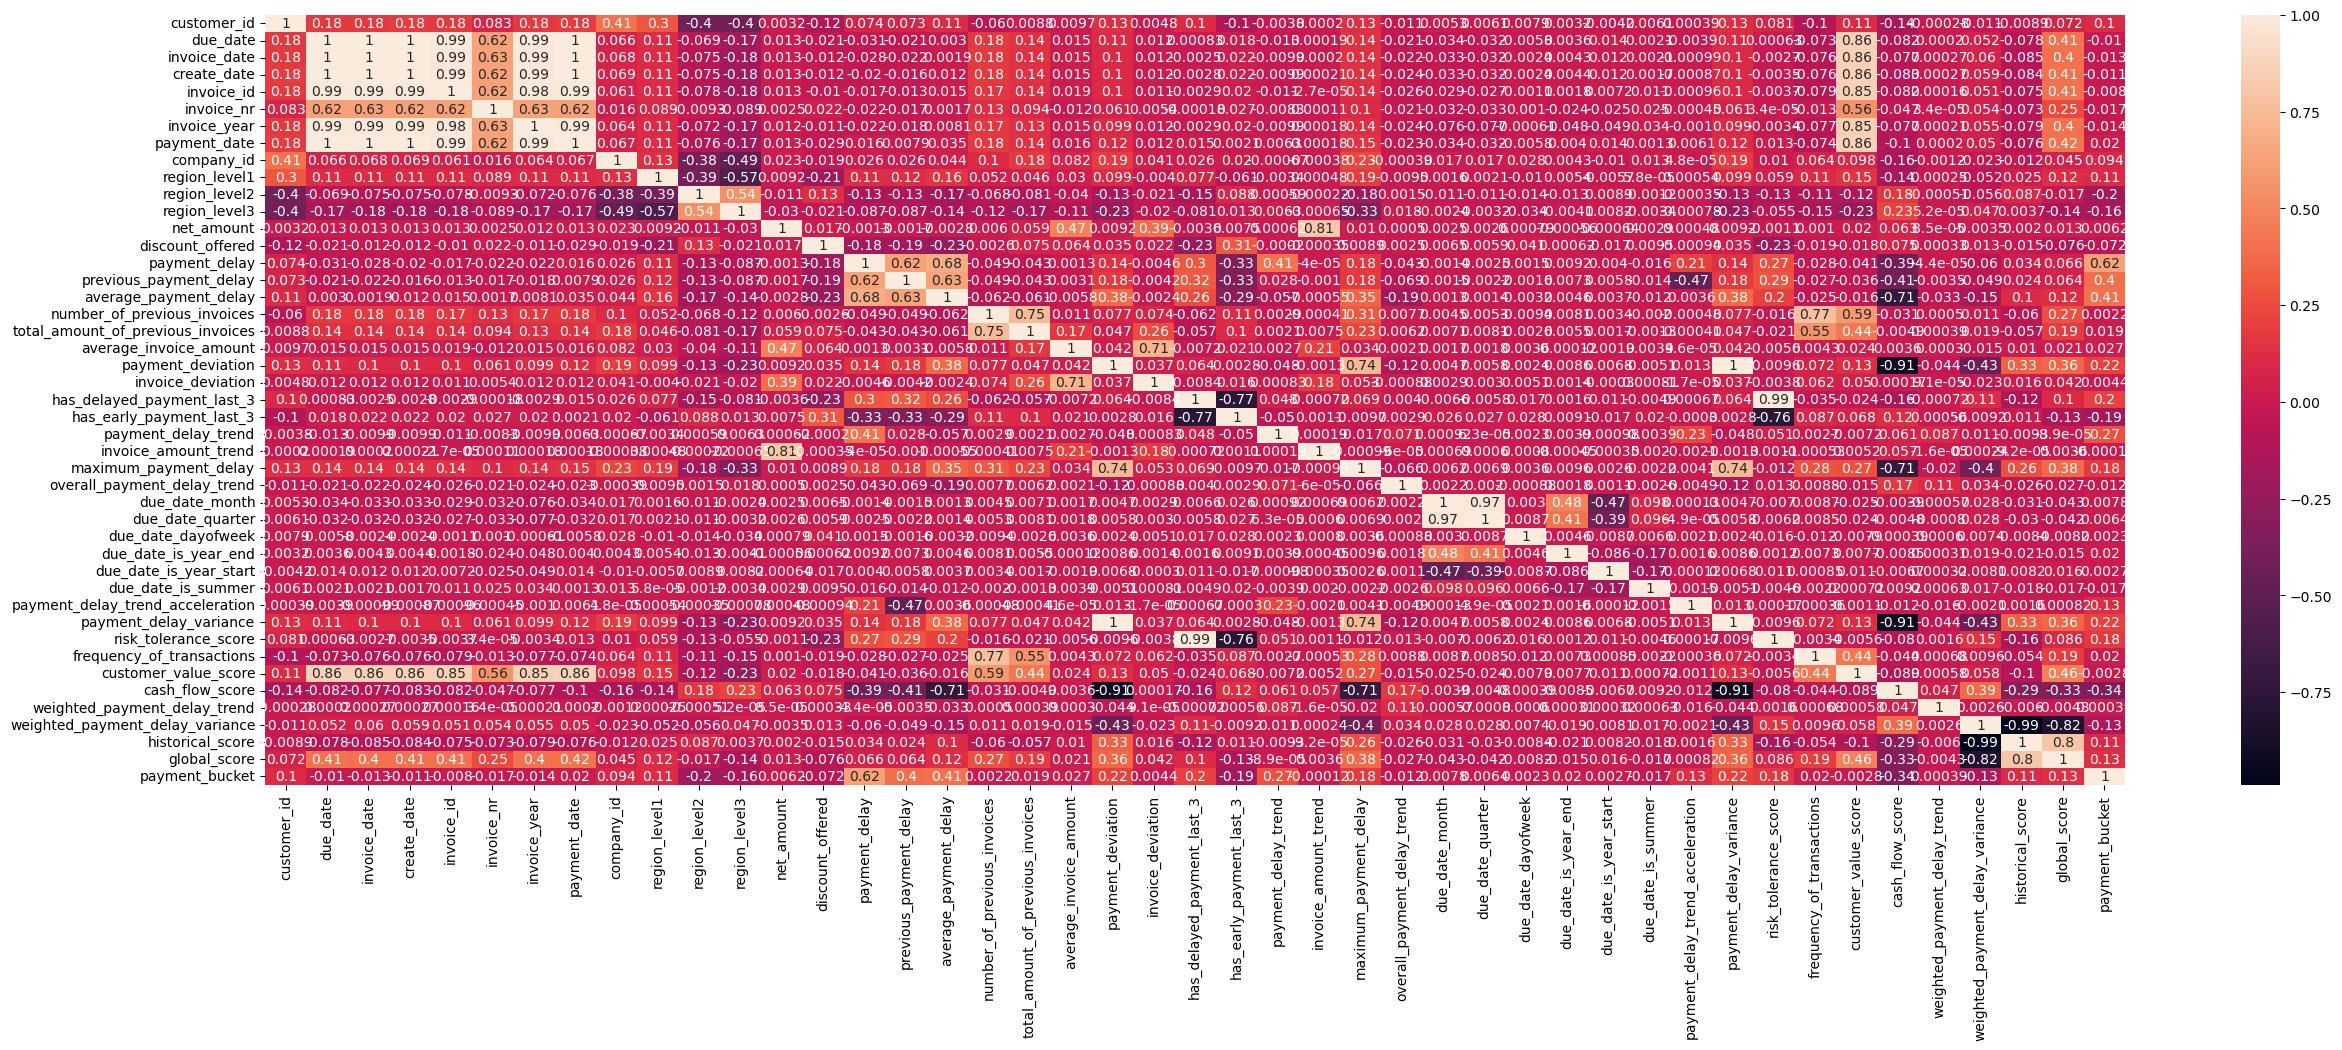

In [29]:
correlations = df.corr()
plt.subplots(figsize=(30, 10))
sns.heatmap(correlations, annot=True)

## 2. Prepare data for Machine Learning Algorithm

After understanding and cleaning the data, now we are ready to split the data and train the algorithm.

In [30]:
# Since we are dealing with time series data, we will split the data based on the invoice date.
# We will use data from 2017 to 2021 for training and data from 2022 onwards for testing.

# sort the dataframe by 'invoice_date' and reset the index
df = df.sort_values(by=["customer_id", "company_id", "invoice_date"]).reset_index(
    drop=True
)

# Define mask for training and test sets in real world scenario for production
mask_train = (df["invoice_date"].dt.year >= 2019) & (df["invoice_date"].dt.year < 2023)

mask_test = df["invoice_date"].dt.year >= 2023

# Create training and test sets
train_data = df[mask_train]
test_data = df[mask_test]

# Drop date columns as they are no longer needed
columns_to_remove_before_training = [
    "due_date",
    "invoice_date",
    "create_date",
    "payment_date",
    "payment_delay",
]

train_data.drop(columns_to_remove_before_training, axis=1, inplace=True)
test_data.drop(columns_to_remove_before_training, axis=1, inplace=True)

train_data["payment_bucket"] = train_data["payment_bucket"].astype(int)
test_data["payment_bucket"] = test_data["payment_bucket"].astype(int)

# define target variables
train_target = train_data["payment_bucket"]
test_target = test_data["payment_bucket"]

# Drop the target variable from the training and test sets
train_data.drop("payment_bucket", axis=1, inplace=True)
test_data.drop("payment_bucket", axis=1, inplace=True)

# Define the class weights
class_weights = train_target.value_counts().to_dict()
for key in class_weights.keys():
    class_weights[key] = len(train_target) / class_weights[key]

/var/folders/zp/560xczsj4dd1v4lysbwyvgn40000gn/T/ipykernel_82673/2695600713.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns_to_remove_before_training, axis=1, inplace=True)
/var/folders/zp/560xczsj4dd1v4lysbwyvgn40000gn/T/ipykernel_82673/2695600713.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns_to_remove_before_training, axis=1, inplace=True)
/var/folders/zp/560xczsj4dd1v4lysbwyvgn40000gn/T/ipykernel_82673/2695600713.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [31]:
# Evaluate the model
def evaluate_preds(y_true, y_preds, y_probs):
    """
    Performs evaluation comparison on y_true labels vs. y_preds labels on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average="macro")
    recall = recall_score(y_true, y_preds, average="macro")
    f1 = f1_score(y_true, y_preds, average="macro")
    metric_dict = {
        "accuracy": round(accuracy, 2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2),
    }

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 score: {f1 * 100:.2f}%")

    # Confusion matrix
    confusion_matrix = pd.crosstab(
        y_true, y_preds, rownames=["Actual"], colnames=["Predicted"]
    )
    print("Confusion matrix:")
    print(confusion_matrix)

    # Evaluate per class metrics
    class_metrics = classification_report(y_true, y_preds, output_dict=True)
    print("Per class metrics:")
    for class_label, metrics in class_metrics.items():
        if isinstance(metrics, dict):  # Skip entries that are not dictionaries
            print(f"For class {class_label}:")
            print(f"\tPrecision: {metrics['precision'] * 100:.2f}%")
            print(f"\tRecall: {metrics['recall'] * 100:.2f}%")
            print(f"\tF1 score: {metrics['f1-score'] * 100:.2f}%")

    return metric_dict

### 2.1 Create the Models

We are aiming to predict the delay of payment in days for each invoice. 

For this purpose we will use our data to train different regression algorithms. For each algorithm we will measure different error scores and accuracy with the test data.

For this excercise we will use following algorithms:
- XGboost Regressor
- Random Forest Classifier
- Logistic Regression
- Light GBM Classifier

Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(train_data, train_target)

y_preds = model.predict(test_data)

y_probs = model.predict_proba(test_data)

metrics = evaluate_preds(y_true=test_target, y_preds=y_preds, y_probs=y_probs)

metrics

Accuracy: 94.09%
Precision: 73.86%
Recall: 67.45%
F1 score: 69.94%
Confusion matrix:
Predicted       0     1     2    3    4
Actual                                 
0          141798  1731    80   20   35
1            4037  8724   591   42   45
2             421  1158  2484  212   96
3             114   115   490  620  245
4              84    29    51  108  945
Per class metrics:
For class 0:
	Precision: 96.82%
	Recall: 98.70%
	F1 score: 97.75%
For class 1:
	Precision: 74.20%
	Recall: 64.92%
	F1 score: 69.25%
For class 2:
	Precision: 67.21%
	Recall: 56.83%
	F1 score: 61.58%
For class 3:
	Precision: 61.88%
	Recall: 39.14%
	F1 score: 47.95%
For class 4:
	Precision: 69.18%
	Recall: 77.65%
	F1 score: 73.17%
For class macro avg:
	Precision: 73.86%
	Recall: 67.45%
	F1 score: 69.94%
For class weighted avg:
	Precision: 93.64%
	Recall: 94.09%
	F1 score: 93.80%


{'accuracy': 0.94, 'precision': 0.74, 'recall': 0.67, 'f1': 0.7}

XGboost

In [33]:
# fitting the model

model = xgb.XGBClassifier()

model.fit(train_data, train_target)

y_preds = model.predict(test_data)

y_probs = model.predict_proba(test_data)

metrics = evaluate_preds(y_true=test_target, y_preds=y_preds, y_probs=y_probs)

metrics

Accuracy: 94.50%
Precision: 72.60%
Recall: 75.30%
F1 score: 73.27%
Confusion matrix:
Predicted       0     1     2    3     4
Actual                                  
0          140780  2579   140   36   129
1            2717  9873   635  107   107
2             223  1023  2598  357   170
3              47    78   224  911   324
4              31     9    25   80  1072
Per class metrics:
For class 0:
	Precision: 97.90%
	Recall: 97.99%
	F1 score: 97.95%
For class 1:
	Precision: 72.80%
	Recall: 73.47%
	F1 score: 73.13%
For class 2:
	Precision: 71.73%
	Recall: 59.44%
	F1 score: 65.01%
For class 3:
	Precision: 61.10%
	Recall: 57.51%
	F1 score: 59.25%
For class 4:
	Precision: 59.49%
	Recall: 88.09%
	F1 score: 71.02%
For class macro avg:
	Precision: 72.60%
	Recall: 75.30%
	F1 score: 73.27%
For class weighted avg:
	Precision: 94.51%
	Recall: 94.50%
	F1 score: 94.47%


{'accuracy': 0.94, 'precision': 0.73, 'recall': 0.75, 'f1': 0.73}

Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(train_data, train_target)

y_preds = model.predict(test_data)

y_probs = model.predict_proba(test_data)

metrics = evaluate_preds(y_true=test_target, y_preds=y_preds, y_probs=y_probs)

metrics

/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 87.45%
Precision: 17.49%
Recall: 20.00%
F1 score: 18.66%
Confusion matrix:
Predicted       0
Actual           
0          143664
1           13439
2            4371
3            1584
4            1217
Per class metrics:
For class 0:
	Precision: 87.45%
	Recall: 100.00%
	F1 score: 93.31%
For class 1:
	Precision: 0.00%
	Recall: 0.00%
	F1 score: 0.00%
For class 2:
	Precision: 0.00%
	Recall: 0.00%
	F1 score: 0.00%
For class 3:
	Precision: 0.00%
	Recall: 0.00%
	F1 score: 0.00%
For class 4:
	Precision: 0.00%
	Recall: 0.00%
	F1 score: 0.00%
For class macro avg:
	Precision: 17.49%
	Recall: 20.00%
	F1 score: 18.66%
For class weighted avg:
	Precision: 76.48%
	Recall: 87.45%
	F1 score: 81.60%


/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomas/Documents/data_science/payment_delay/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

{'accuracy': 0.87, 'precision': 0.17, 'recall': 0.2, 'f1': 0.19}

LGBM Classifier

In [39]:
model = lgb.LGBMClassifier()

model.fit(train_data, train_target)

y_preds = model.predict(test_data)

y_probs = model.predict_proba(test_data)

metrics = evaluate_preds(y_true=test_target, y_preds=y_preds, y_probs=y_probs)

metrics

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6596
[LightGBM] [Info] Number of data points in the train set: 1095165, number of used features: 39
[LightGBM] [Info] Start training from score -0.171144
[LightGBM] [Info] Start training from score -2.376731
[LightGBM] [Info] Start training from score -3.404806
[LightGBM] [Info] Start training from score -4.360603
[LightGBM] [Info] Start training from score -3.992038
Accuracy: 94.50%
Precision: 73.87%
Recall: 75.89%
F1 score: 74.70%
Confusion matrix:
Predicted       0      1     2    3     4
Actual                                   
0          140170   3199   186   54    55
1            2216  10366   719   78    60
2             205    958  2766  338   104
3              57     86   266  939   236
4              49     19    45  104  1

{'accuracy': 0.95, 'precision': 0.74, 'recall': 0.76, 'f1': 0.75}

### 2.2 Hypertuning Parameters

We can conclude, that we got the best results from the LGBM Classifier in the excercise above.

We will continue and find the best parameters to use with this model and try to increase the accuracy of the model.

In [ ]:
# Define the model

model = lgb.LGBMClassifier(
    objective="multiclass",
    metric="multiclass",
    n_jobs=-1,
    verbose=-1,
    random_state=0,
    class_weight=class_weights,
    learning_rate=0.022550720790521145,
    max_depth=20,
    min_child_samples=88,
    n_estimators=1580,
    num_leaves=16917,
    reg_alpha=0.513841643356537,
    reg_lambda=2.1667566844499695,
    subsample=0.7859753700282479,
    subsample_freq=8,
)

model.fit(train_data, train_target)

y_preds = model.predict(test_data)

y_probs = model.predict_proba(test_data)

metrics = evaluate_preds(y_true=test_target, y_preds=y_preds, y_probs=y_probs)

metrics

Accuracy: 94.70%
Precision: 74.04%
Recall: 76.20%
F1 score: 74.81%
Confusion matrix:
Predicted       0      1     2    3     4
Actual                                   
0          140619   2794   128   45    78
1            2394  10141   750   79    75
2             210    868  2863  319   111
3              58     79   276  898   273
4              38     14    25  100  1040
Per class metrics:
For class 0:
	Precision: 98.12%
	Recall: 97.88%
	F1 score: 98.00%
For class 1:
	Precision: 72.98%
	Recall: 75.46%
	F1 score: 74.20%
For class 2:
	Precision: 70.83%
	Recall: 65.50%
	F1 score: 68.06%
For class 3:
	Precision: 62.32%
	Recall: 56.69%
	F1 score: 59.37%
For class 4:
	Precision: 65.95%
	Recall: 85.46%
	F1 score: 74.45%
For class macro avg:
	Precision: 74.04%
	Recall: 76.20%
	F1 score: 74.81%
For class weighted avg:
	Precision: 94.75%
	Recall: 94.70%
	F1 score: 94.71%


{'accuracy': 0.95, 'precision': 0.74, 'recall': 0.76, 'f1': 0.75}

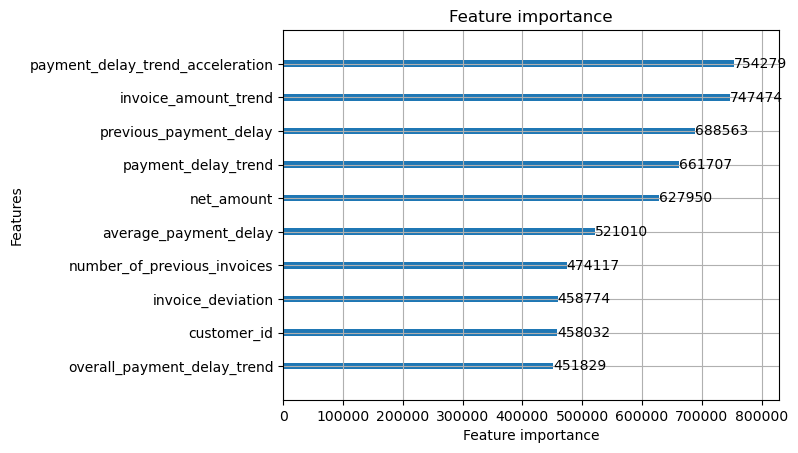

In [ ]:
# make a grapph to show the feature importance
lgb.plot_importance(model, max_num_features=10, importance_type="split")
plt.show()

## 3. Use the model to create Delay Buckets

After having optimized our model we now can predict with a high level of accuracy the amount of days the payment of an invoice will be delayed.

Based on these results we will create different buckets and them on a new column to our Dataframe.

The Buckets will be as follows:
- 0-15 Days
- 16-30 Days
- 31-45 Days
- 46-60 Days
- Greater than 60 Days

In [42]:
# Save the predictions
test_data["prediction"] = y_preds
bucket_mapping = {
    0: "0-15days",
    1: "15-30days",
    2: "30-45days",
    3: "45-60days",
    4: "60days",
}
test_data["prediction"] = test_data["prediction"].replace(bucket_mapping)

/var/folders/zp/560xczsj4dd1v4lysbwyvgn40000gn/T/ipykernel_82673/3565282191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["prediction"] = y_preds
/var/folders/zp/560xczsj4dd1v4lysbwyvgn40000gn/T/ipykernel_82673/3565282191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["prediction"] = test_data["prediction"].replace(bucket_mapping)


### 3.1 Export the data and the model

In [44]:
test_data.to_csv(processed_path + "predictions.csv")

In [ ]:
pickle.dump(model, open("model.pkl", "wb"))